In [1]:
import warnings
warnings.simplefilter(action='ignore')

import seaborn as sns 
import numpy as np
import pandas as pd 
import pathlib
import json 
from matplotlib import pyplot as plt 
plt.style.use('seaborn')

gc = ['#f7fcf5','#e5f5e0','#c7e9c0','#a1d99b','#74c476','#41ab5d','#238b45','#006d2c','#00441b']
gc.reverse()
bc = ['#f7fbff','#deebf7','#c6dbef','#9ecae1','#6baed6','#4292c6','#2171b5','#08519c','#08306b']
bc.reverse()

colors = []
for i in range(5):
    colors.append(gc[i])
    colors.append(bc[i])

colors.append('#000000')

intents_and_functions = ['radio', "FindManager", 'email_q', "Tomorrow", 'email_qc', "PlaceHasFeature", 'quirky', "DoNotConfirm", 'traffic', "FenceAttendee", "Overall"]
color_mapping = {k:v for k,v in zip(intents_and_functions, colors)}

marker_lookup = {'radio': "d", "FindManager": "o", 'email_q': "H", "Tomorrow": "P", 'email_qc': "^", "PlaceHasFeature": ">", 'quirky': "s", "DoNotConfirm": "<", 'traffic': "8", "FenceAttendee": "p", "Overall": "D"}


title_font_size=18


In [2]:
name_lookup = {"valid_em": "Exact Match", "valid_coarse": "Coarse", "valid_fine": "Fine", "valid_precision": "Precision", 
               "test_em": "Exact Match", "test_coarse": "Coarse", "test_fine": "Fine", "test_precision": "Precision"}
def plot_calflow(datas, 
                title, 
                savepath=None, 
                fixed_axis=False, 
                prefix="valid", 
                xs = ["5000","10000","20000","50000","100000","max"], 
                ax = None, 
                use_total=True, 
                use_coarse=False, 
                ymin = None, 
                ymax=None,
                axis_title=False,
                show_legend=False,
                legend_kws={}):

    all_data = {}
    for i, (fxn, data) in enumerate(datas):
        col_names = ['train', fxn]
        if use_total or i == 0:
            col_names.append("Overall")
        if use_coarse:
            col_names.append(f"{prefix}_coarse")

        data['train'] = data['train'].astype(str)
        data = data.rename(columns={"train": "train", "function": "function", "seed": "seed", "test_coarse": "test_coarse", f"{prefix}_em": f"Overall", f"{prefix}_fine": fxn} )
        minor_data = data[col_names]
        minor_data = pd.melt(minor_data, id_vars=['train'])
        all_data[fxn] = minor_data
    big_data = pd.concat(all_data.values(), ignore_index=True)

    if ax is None:
        fig, ax = plt.subplots()

    no_total_data = big_data[big_data['variable'] != "Overall"]
    total_data = big_data[big_data['variable'] == "Overall"]

    sns.lineplot(data=no_total_data, 
                x="train", 
                y="value",  
                hue="variable", 
                err_style=None, 
                style = "variable", 
                markers=marker_lookup,
                dashes=False,
                markersize=9,
                linewidth=1.8,
                ax=ax, 
                palette=color_mapping)

    sns.lineplot(data=total_data, 
                x="train", 
                y="value",  
                hue="variable", 
                err_style=None, 
                style = "variable", 
                markers=marker_lookup,
                dashes=[(2,2)],
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)
    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    if fixed_axis:
        ax.ylim(20, 100)
    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    if ymax is not None:
        ax.set_ylim(top=ymax)

    ax.set_xticklabels(['5k', '10k', '20k', '50k', '100k', 'max'])
    ax.set_title(title, fontsize=title_font_size, fontfamily="DejaVu Serif")
    ax.set_ylabel("")
    if axis_title:
        ax.set_xlabel("Total Training Examples")
    else:
        ax.set_xlabel("") 

    if show_legend: 
        ax.legend(**legend_kws)
    else:
        ax.legend([], [], frameon=False)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)



In [16]:


def get_data_from_dir(root_data_dir, fxn, seeds):
    all_data = pd.DataFrame(columns=["train", "function", "seed", "total_acc", f"{fxn}_acc", "intent"], dtype=object)
    root_data_dir = pathlib.Path(root_data_dir).joinpath(str(fxn))
    for seed in seeds:
        data_dir = root_data_dir.joinpath(f"{seed}_seed")

        globs = [x for x in data_dir.glob("*/test_metrics.json")]
        globs = sorted(globs, key = lambda x: int(x.parent.name.split("_")[0]))

        for path in globs:
            try:
                data = json.load(open(path))
            except json.JSONDecodeError:
                data = {}
                data['acc'] = np.nan
                data[f'{fxn}_acc'] = np.nan

            setting = path.parent.name
            num_train, num_fxn = setting.split("_")
            num_train, num_fxn = int(num_train), int(num_fxn)

            to_add = {"train": str(num_train), "function": num_fxn, "seed": seed, 
                     "total_acc": data['acc'] * 100, "intent": fxn, f"{fxn}_acc": data[f"{fxn}_acc"] * 100}
            all_data = all_data.append(to_add, ignore_index=True)

    return all_data 

name_mapping = {"50": "radio", "66": "traffic", "15": "email_q", "16": "email_qc", "27": "quirky"}
def plot_intent(data_dirs, 
                seeds = [12, 31, 64], 
                title=None, 
                savepath=None, 
                xs = [750, 1500, 3000, 7500, 15000, 18000], 
                ymax=None,
                ymin=None,
                ax = None, 
                fxn_split = 15,
                axis_title = None,
                show_legend=False, 
                legend_kws = {}):
    all_data = {}

    for i, (intent, data_dir) in enumerate(data_dirs):
        data = get_data_from_dir(data_dir, intent, seeds)
        data = data[data['function'] == fxn_split]
        if i == 0:
            col_names = ["train", "total_acc", f"{intent}_acc"]
        else:
            col_names = ["train", f"{intent}_acc"]

        minor_data = data[col_names]
        minor_data = minor_data.rename(columns={"train": "train", 
                                        "total_acc": "Overall", 
                                        f"{intent}_acc": name_mapping[str(intent)]})
        minor_data = pd.melt(minor_data, id_vars=['train'])
        all_data[intent] = minor_data

    if ax is None:
        fig, ax = plt.subplots()

    big_data = pd.concat(all_data.values(), ignore_index=True) 

    # custom_palette = [color_mapping[k] for k in sorted([ '15', 'total', '16', '27', '50', '66'])]
    # custom_palette = sns.color_palette(custom_palette)
    # print(custom_palette)

    no_total_data = big_data[big_data['variable'] != "Overall"]
    total_data = big_data[big_data['variable'] == "Overall"]

    sns.lineplot(data=no_total_data, 
                x="train", 
                y="value",  
                hue="variable", 
                err_style=None,
                markers=marker_lookup,
                style="variable",
                dashes=False, 
                markersize=9,
                linewidth=1.8,
                ax=ax, 
                palette=color_mapping)

    sns.lineplot(data=total_data, 
                x="train", 
                y="value",  
                hue="variable", 
                err_style=None,
                markers=marker_lookup,
                style="variable",
                dashes=[(2,2)],
                markersize=7,
                linewidth=3,
                ax=ax, 
                palette=color_mapping)

    sns.despine(ax=ax, top=True, right=True, left=False, bottom=False)

    if ymin is not None:
        ax.set_ylim(bottom=ymin)
    if ymax is not None:
        ax.set_ylim(top=ymax)

    ax.set_xticklabels(['0.75k', '1.5k', '3k', '7.5k', '15k', 'max'])
    ax.set_title(title, fontsize=title_font_size, fontfamily="DejaVu Serif")
    ax.set_ylabel("")

    if axis_title is not None:
        ax.set_xlabel("Total Training Examples")
    else:
        ax.set_xlabel("") 

    if show_legend:
        ax.legend(**legend_kws)
    else:
        ax.legend([], [], frameon=False)

    if savepath is not None:
        plt.tight_layout()
        plt.savefig(savepath)




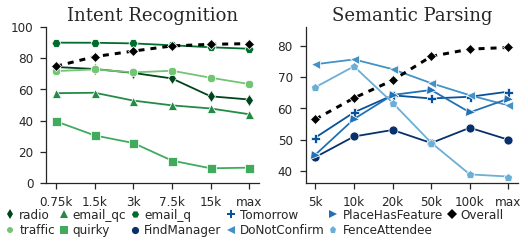

In [17]:
# Figure 1: showing decreasing accuracy for both intent and calflow 
from matplotlib.legend_handler import HandlerLine2D
import matplotlib 
# plt.rcParams.update({'font.size': 12, 'lines.markeredgewidth': 5, 'font.family': "DejaVu Serif"})


def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(0)

handler_map={plt.Line2D : HandlerLine2D(update_func=update)}

fig, ax = plt.subplots(1, 2, sharex=False, sharey=False, figsize = (7.5, 3.2))

legend_kws_intent = dict(ncol=3, borderpad=0.0, labelspacing=0.2, columnspacing=1.0, handlelength=0.5,
                bbox_to_anchor=(0.9, -0.20), loc=1, handletextpad=0.5, handler_map=handler_map)


matplotlib.rcParams.update({'font.size': 16})

sns.set(context='paper')
sns.set(font_scale = 1.09)
sns.set_style(style='ticks')

plot_intent([(50, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"),
             (66, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (16, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (27, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/"), 
             (15, "/brtx/603-nvme1/estengel/intent_fixed_test/intent/")], [12, 31, 64],
              title = f"Intent Recognition", fxn_split=30, ax=ax[0],
              show_legend=False,
              axis_title=None,
              ymax=100,
              ymin=0,
            #   legend_kws=legend_kws_intent
)

fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_transformer_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_transformer_test.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_transformer_test.csv", index_col=0)


datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]
plot_calflow(datas, 
            title = "Semantic Parsing",
            prefix="test", 
            ax=ax[1], 
            use_coarse=False, 
            use_total=False,
            axis_title=None,
            ymin=None,
            ymax=86,
            show_legend=False,
            # legend_kws=legend_kws_calflow
            )

legend_kws = dict(ncol=6, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5, markerscale=1.2,
                bbox_to_anchor=(0.95, 0.09), loc=1, handletextpad=0.5, handler_map=handler_map)

lines1, handles1 = ax[0].get_legend_handles_labels()
lines2, handles2 = ax[1].get_legend_handles_labels()

lines_and_handles = zip(lines1, handles1)
lines_and_handles = [x for x in lines_and_handles if x[1] != 'Overall']
lines1, handles1 = [list(x) for x in zip(*lines_and_handles)]

lines = lines1+lines2
handles = handles1 + handles2

plt.figlegend(lines, handles, **legend_kws)
plt.tight_layout()
plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/fig1_intent_and_calflow.pdf", bbox_inches='tight')

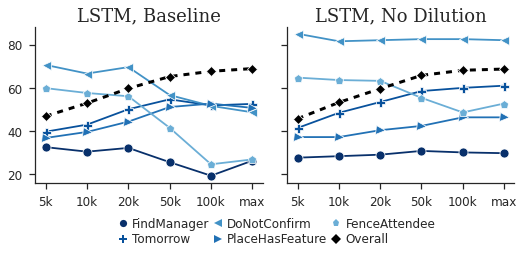

In [5]:
fig, ax = plt.subplots(1,2, figsize = (7.5, 3.2), sharex=True, sharey=True)
fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_vanilla_lstm_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_vanilla_lstm_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_vanilla_lstm_100.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_vanilla_lstm_test.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_vanilla_lstm_test.csv", index_col=0)


legend_kws_source = dict(ncol=2, fontsize=11, borderpad=0.0, labelspacing=0.2, columnspacing=1.0, handlelength=0.5,
                bbox_to_anchor=(0.9, -0.20), loc=1, handletextpad=0.5, handler_map=handler_map)



datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]

for i, (name, df) in enumerate(datas):
    df['train'] = df['train'].astype(str)
    datas[i] = (name, df)

matplotlib.rcParams.update({'font.size': 16})
sns.set(context='paper')
sns.set(font_scale = 1.09)
sns.set_style(style='ticks')

plot_calflow(datas, 
            title = "LSTM, Baseline", 
            prefix="test", 
            ax=ax[0], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=None,
            legend_kws=legend_kws_source
            )


fm_ns_data = pd.read_csv("~/papers/incremental_function_learning/results/lstm_no_source/FindManager_vanilla_lstm_no_source.csv", index_col=0)
tomorrow_ns_data = pd.read_csv("~/papers/incremental_function_learning/results/lstm_no_source/Tomorrow_vanilla_lstm_no_source.csv", index_col=0)
donotconfirm_ns_data =  pd.read_csv("~/papers/incremental_function_learning/results/lstm_no_source/DoNotConfirm_vanilla_lstm_no_source.csv", index_col=0)
placehasfeature_ns_data = pd.read_csv("~/papers/incremental_function_learning/results/lstm_no_source/PlaceHasFeature_vanilla_lstm_no_source.csv", index_col=0)
fenceattendee_ns_data = pd.read_csv("~/papers/incremental_function_learning/results/lstm_no_source/FenceAttendee_vanilla_lstm_no_source.csv", index_col=0)


datas = [("FindManager", fm_ns_data), 
("Tomorrow", tomorrow_ns_data), 
("DoNotConfirm", donotconfirm_ns_data), 
("PlaceHasFeature", placehasfeature_ns_data), 
("FenceAttendee", fenceattendee_ns_data)]

for i, (name, df) in enumerate(datas):
    df['train'] = df['train'].astype(str)
    datas[i] = (name, df)


legend_kws_no_source = dict(ncol=3, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5, markerscale=1.2,
                bbox_to_anchor=(0.83, 0.05), loc=1, handletextpad=0.5, handler_map=handler_map)

plot_calflow(datas, 
            title = "LSTM, No Dilution", 
            prefix="test", 
            ax=ax[1], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=None,
            show_legend=True,
            legend_kws=legend_kws_no_source
            )

handles, labels = ax[1].get_legend_handles_labels()
ax[1].legend([],[])
fig.legend(handles, labels, **legend_kws_no_source)


plt.tight_layout()

plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/lstm_calflow.pdf", bbox_inches='tight')


In [29]:
fig, ax = plt.subplots(2,2, figsize = (7.5, 6.4), sharex=True, sharey=True)
matplotlib.rcParams.update({'font.size': 16})
sns.set(context='paper')
sns.set(font_scale = 1.09)
sns.set_style(style='ticks')

## BERT 
fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_transformer_test.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_transformer_test.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_transformer_full_test.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_transformer_test.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_transformer_test.csv", index_col=0)


datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]
plot_calflow(datas, 
            title = "BERT-base",
            prefix="test", 
            ax=ax[0,0], 
            use_coarse=False, 
            use_total=False,
            axis_title=None,
            ymin=None,
            ymax=None,
            show_legend=False,
            # legend_kws=legend_kws_calflow
            )
## ALBERT 
fm_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/FindManager_albert.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/Tomorrow_albert.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/DoNotConfirm_albert.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/PlaceHasFeature_albert.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/FenceAttendee_albert.csv", index_col=0)


datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]
plot_calflow(datas, 
            title = "ALBERT Base",
            prefix="test", 
            ax=ax[0,1], 
            use_coarse=False, 
            use_total=False,
            axis_title=None,
            ymin=None,
            ymax=None,
            show_legend=False,
            # legend_kws=legend_kws_calflow
            )

## ROBERTA-base

fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_roberta.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_roberta.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_roberta.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_roberta.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_roberta.csv", index_col=0)


datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), 
         ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]

for i, (name, df) in enumerate(datas):
    df['train'] = df['train'].astype(str)
    datas[i] = (name, df)


plot_calflow(datas, 
            title = "RoBERTa Base", 
            prefix="test", 
            ax=ax[1,0], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=None,
            # legend_kws=legend_kws_source
            )

## ROBERTA-large 
fm_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/FindManager_roberta_large.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/Tomorrow_roberta_large.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/DoNotConfirm_roberta_large.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/PlaceHasFeature_roberta_large.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/FenceAttendee_roberta_large.csv", index_col=0)

datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), 
         ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]

for i, (name, df) in enumerate(datas):
    df['train'] = df['train'].astype(str)
    datas[i] = (name, df)


plot_calflow(datas, 
            title = "RoBERTa-large", 
            prefix="test", 
            ax=ax[1,1], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=None,
            # legend_kws=legend_kws_source
            )

legend_kws = dict(ncol=3, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5, markerscale=1.2,
                bbox_to_anchor=(0.95, 0.09), loc=1, handletextpad=0.5, handler_map=handler_map)

lines1, handles1 = ax[0,0].get_legend_handles_labels()
# lines2, handles2 = ax[1].get_legend_handles_labels()

lines_and_handles = zip(lines1, handles1)
# lines_and_handles = [x for x in lines_and_handles if x[1] != 'Overall']
lines1, handles1 = [list(x) for x in zip(*lines_and_handles)]

# lines = lines1+lines2
lines = lines1
handles = handles1 + handles2

plt.figlegend(lines, handles, **legend_kws)
plt.tight_layout()
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend([],[])
# fig.legend(handles, labels, **legend_kws_no_source)


plt.tight_layout()

plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/roberta.pdf", bbox_inches='tight')


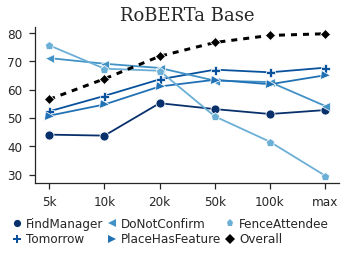

In [25]:



fig, ax = plt.subplots(1,2, figsize = (7.5, 3.2), sharex=True, sharey=True)
fm_data = pd.read_csv("~/papers/incremental_function_learning/results/FindManager_roberta.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/Tomorrow_roberta.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/DoNotConfirm_roberta.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/PlaceHasFeature_roberta.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/FenceAttendee_roberta.csv", index_col=0)


legend_kws_source = dict(ncol=2, fontsize=11, borderpad=0.0, labelspacing=0.2, columnspacing=1.0, handlelength=0.5,
                bbox_to_anchor=(0.9, -0.20), loc=1, handletextpad=0.5, handler_map=handler_map)



datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), 
         ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]

for i, (name, df) in enumerate(datas):
    df['train'] = df['train'].astype(str)
    datas[i] = (name, df)

matplotlib.rcParams.update({'font.size': 16})
sns.set(context='paper')
sns.set(font_scale = 1.09)
sns.set_style(style='ticks')

plot_calflow(datas, 
            title = "RoBERTa Base", 
            prefix="test", 
            ax=ax[0], 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=None,
            legend_kws=legend_kws_source
            )

fm_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/FindManager_albert.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/Tomorrow_albert.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/DoNotConfirm_albert.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/PlaceHasFeature_albert.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/albert/FenceAttendee_albert.csv", index_col=0)


datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]
plot_calflow(datas, 
            title = "ALBERT Base",
            prefix="test", 
            ax=ax[1], 
            use_coarse=False, 
            use_total=False,
            axis_title=None,
            ymin=None,
            ymax=86,
            show_legend=False,
            # legend_kws=legend_kws_calflow
            )

legend_kws = dict(ncol=6, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5, markerscale=1.2,
                bbox_to_anchor=(0.95, 0.09), loc=1, handletextpad=0.5, handler_map=handler_map)

lines1, handles1 = ax[0].get_legend_handles_labels()
# lines2, handles2 = ax[1].get_legend_handles_labels()

lines_and_handles = zip(lines1, handles1)
lines_and_handles = [x for x in lines_and_handles if x[1] != 'Overall']
lines1, handles1 = [list(x) for x in zip(*lines_and_handles)]

# lines = lines1+lines2
lines = lines1
handles = handles1 + handles2


fig, ax = plt.subplots(1,1, figsize = (5.0, 3.2), sharex=True, sharey=True)
fm_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/FindManager_roberta_large.csv", index_col=0)
tomorrow_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/Tomorrow_roberta_large.csv", index_col=0)
donotconfirm_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/DoNotConfirm_roberta_large.csv", index_col=0)
placehasfeature_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/PlaceHasFeature_roberta_large.csv", index_col=0)
fenceattendee_data = pd.read_csv("~/papers/incremental_function_learning/results/roberta_large/FenceAttendee_roberta_large.csv", index_col=0)


legend_kws_source = dict(ncol=2, fontsize=11, borderpad=0.0, labelspacing=0.2, columnspacing=1.0, handlelength=0.5,
                bbox_to_anchor=(0.9, -0.20), loc=1, handletextpad=0.5, handler_map=handler_map)



datas = [("FindManager", fm_data), ("Tomorrow", tomorrow_data), ("DoNotConfirm", donotconfirm_data), 
         ("PlaceHasFeature", placehasfeature_data), ("FenceAttendee", fenceattendee_data)]

for i, (name, df) in enumerate(datas):
    df['train'] = df['train'].astype(str)
    datas[i] = (name, df)

matplotlib.rcParams.update({'font.size': 16})
sns.set(context='paper')
sns.set(font_scale = 1.09)
sns.set_style(style='ticks')

plot_calflow(datas, 
            title = "RoBERTa Base", 
            prefix="test", 
            ax=ax, 
            use_coarse=False, 
            use_total=False,
            ymin=None,
            ymax=None,
            legend_kws=legend_kws_source
            )

legend_kws = dict(ncol=3, borderpad=0.0, labelspacing=0.2, columnspacing=0.5, handlelength=0.5, markerscale=1.2,
                bbox_to_anchor=(0.95, 0.05), loc=1, handletextpad=0.5, handler_map=handler_map)

lines1, handles1 = ax.get_legend_handles_labels()
# lines2, handles2 = ax[1].get_legend_handles_labels()

lines_and_handles = zip(lines1, handles1)
# lines_and_handles = [x for x in lines_and_handles if x[1] != 'Overall']
lines1, handles1 = [list(x) for x in zip(*lines_and_handles)]

# lines = lines1+lines2
lines = lines1
handles = handles1 + handles2

plt.figlegend(lines, handles, **legend_kws)
plt.tight_layout()
# handles, labels = ax[1].get_legend_handles_labels()
# ax[1].legend([],[])
# fig.legend(handles, labels, **legend_kws_no_source)


plt.tight_layout()

plt.savefig("/home/estengel/papers/incremental_function_learning/figures/for_paper/roberta_large.pdf", bbox_inches='tight')


